In [7]:
import os
import tensorflow 
import numpy as np 
import pandas as pd 
from collections import Counter
import random
import IPython
from IPython.display import Image, Audio
import music21
from music21 import *
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adamax
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
import sys
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
np.random.seed(42)

In [30]:
gpu_devices = tensorflow.config.list_physical_devices('GPU')
details = tensorflow.config.experimental.get_device_details(gpu_devices[0])
details.get('device_name', 'Unknown GPU')

'NVIDIA GeForce RTX 4070 Laptop GPU'

First we will make a list of all the songs in the Chopin folder parsed as music21 stream. Then we will be creating a function to extract chords and notes out of the data creating a corpus.

In [31]:
filepath = "./data/chopin/"
#Getting midi files
all_midis= []
for i in os.listdir(filepath):
    if i.endswith(".mid"):
        tr = filepath+i
        midi = converter.parse(tr)
        all_midis.append(midi)

Next, we get the components out of these streams of MIDI files. The midi files only have the piano included as mentioned in the dataset. So the components of the file would be either `piano chords` or `piano notes`.

**Note:** The musical notes are the building blocks of the music. It pertains to a pitch associated with a specific audio vibration. Western music utilizes twelve musical notes.

Chord: A group of notes that sound good together is a chord.

The music21 stream that was created in the above cell contains both, chords and notes, we will extract them in the form of notes and obtain a series of notes in the musical composition.

In [32]:
def extract_notes(file):
    notes = []
    pick = None
    for j in file:
        songs = instrument.partitionByInstrument(j)
        for part in songs.parts:
            pick = part.recurse()
            for element in pick:
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                elif isinstance(element, chord.Chord):
                    notes.append(".".join(str(n) for n in element.normalOrder))

    return notes
#Getting the list of notes as Corpus
Corpus= extract_notes(all_midis)
print("Total notes in all the Chopin midis in the dataset:", len(Corpus))

Total notes in all the Chopin midis in the dataset: 57887


So we have our data in the form of a corpus. A list of strings, if you will. Each string indicates a musical note.

In [33]:
print("First fifty values in the Corpus:", Corpus[:50])

First fifty values in the Corpus: ['7.0', 'G3', '0.4', 'E3', '0.4.7', 'A4', '9.11', 'G3', '5.7', '2.5', '2.5.7', 'A4', '9.0', 'G3', '4.7', '0.4', '0.4.7', 'A4', '4.9', 'B3', '4.7', '4.7', '4.7.11', 'C5', '0.5', 'E4', '4.9', '9.0', '9.0.4', '2', '2.6', 'E4', '9.0', 'C4', '9.0.4', '2', '5.7', 'E4', '7.11', 'B3', '4.7.11', '2', '7', 'B3', '2.5', 'F3', '11.2.5', 'A4', '9.0', 'G3']


In [34]:
count_num = Counter(Corpus)
print("Total unique notes in the Corpus:", len(count_num))

Total unique notes in the Corpus: 397


In [35]:
Notes = list(count_num.keys())
Recurrence = list(count_num.values())
#Average recurrenc for a note in Corpus
def Average(lst):
    return sum(lst) / len(lst)
print("Average recurrenc for a note in Corpus:", Average(Recurrence))
print("Most frequent note in Corpus appeared:", max(Recurrence), "times")
print("Least frequent note in Corpus appeared:", min(Recurrence), "time")

Average recurrenc for a note in Corpus: 145.8110831234257
Most frequent note in Corpus appeared: 1627 times
Least frequent note in Corpus appeared: 1 time


Clearly, there are some very rare notes in the melody; some so rare that it was played only once in the whole data. This would create a lot of problems. To spare us the error reports, let us have a look at the frequency of the notes. And for simplicity, we shall be eliminating some of the least occurring notes.

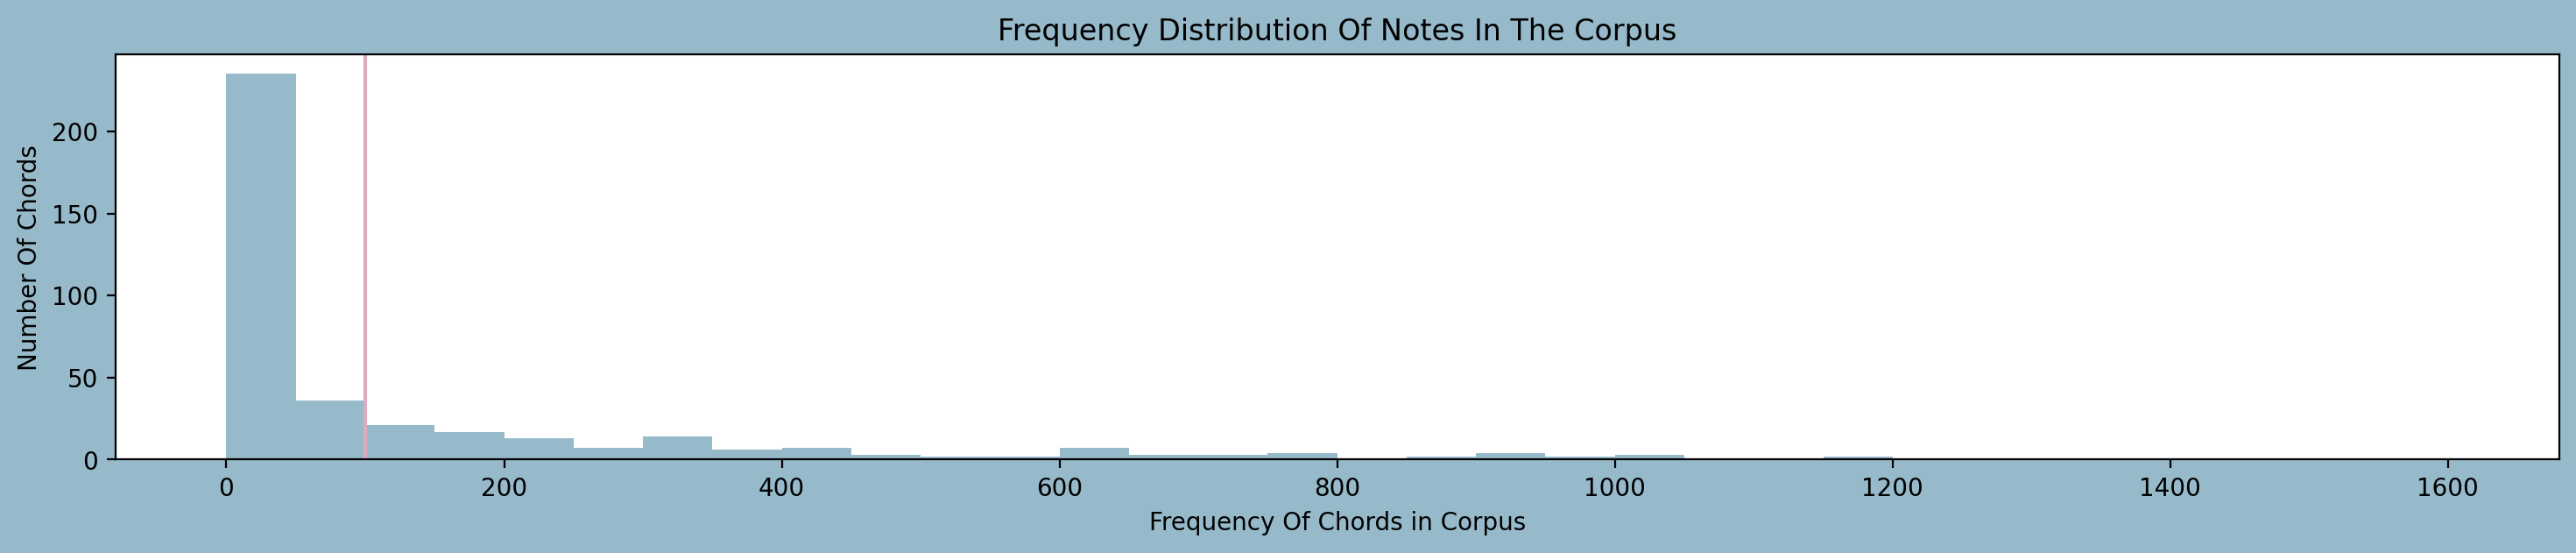

In [36]:
plt.figure(figsize=(18,3),facecolor="#97BACB")
bins = np.arange(0,(max(Recurrence)), 50) 
plt.hist(Recurrence, bins=bins, color="#97BACB")
plt.axvline(x=100,color="#DBACC1")
plt.title("Frequency Distribution Of Notes In The Corpus")
plt.xlabel("Frequency Of Chords in Corpus")
plt.ylabel("Number Of Chords")
plt.show()

We will be taking out the notes that were played less than 100 times.

In [37]:
rare_note = []
for index, (key, value) in enumerate(count_num.items()):
    if value < 100:
        m =  key
        rare_note.append(m)
        
print("Total number of notes that occur less than 100 times:", len(rare_note))

Total number of notes that occur less than 100 times: 271


In [38]:
for element in Corpus:
    if element in rare_note:
        Corpus.remove(element)

print("Length of Corpus after elemination the rare notes:", len(Corpus))

Length of Corpus after elemination the rare notes: 53713


Finally! This is the cleaned data Corpus that we will be using for the music generation. Now we will be preprocessing this Corpus for the training model.

Notes are basically sound waves. In music, we have certain specific combinations of Frequency and Wavelength standardized as said notes. Our Corpus has the name of that note. As we parsed the data at the time of loading we took the help of the music21 library (by nice people at MIT); The library fetches Frequency, Wavelength, duration etc for the given notes.

In [39]:
symb = sorted(list(set(Corpus)))

L_corpus = len(Corpus) #length of corpus
L_symb = len(symb) #length of total unique characters

#Building dictionary to access the vocabulary from indices and vice versa
mapping = dict((c, i) for i, c in enumerate(symb))
reverse_mapping = dict((i, c) for i, c in enumerate(symb))

print("Total number of characters:", L_corpus)
print("Number of unique characters:", L_symb)

Total number of characters: 53713
Number of unique characters: 266


In [40]:
length = 40
features = []
targets = []
for i in range(0, L_corpus - length, 1):
    feature = Corpus[i:i + length]
    target = Corpus[i + length]
    features.append([mapping[j] for j in feature])
    targets.append(mapping[target])
    
    
L_datapoints = len(targets)
print("Total number of sequences in the Corpus:", L_datapoints)

Total number of sequences in the Corpus: 53673


In [41]:
# reshape X and normalize
X = (np.reshape(features, (L_datapoints, length, 1)))/ float(L_symb)
# one hot encode the output variable
y = tensorflow.keras.utils.to_categorical(targets) 

In [42]:
#Taking out a subset of data to be used as seed
X_train, X_seed, y_train, y_seed = train_test_split(X, y, test_size=0.2, random_state=42)

In [43]:
#Initialising the Model
model = Sequential()
#Adding layers
model.add(LSTM(512, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(256))
model.add(Dense(256))
model.add(Dropout(0.1))
model.add(Dense(y.shape[1], activation='softmax'))
#Compiling the model for training  
opt = Adamax(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=opt)

In [44]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 40, 512)           1052672   
                                                                 
 dropout (Dropout)           (None, 40, 512)           0         
                                                                 
 lstm_1 (LSTM)               (None, 256)               787456    
                                                                 
 dense (Dense)               (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 266)               68362     
                                                                 
Total params: 1,974,282
Trainable params: 1,974,282
Non-

In [45]:
history = model.fit(X_train, y_train, batch_size=256, epochs=200)

Epoch 1/200
168/168 [==============================] - 21s 23ms/step - loss: 4.7647
Epoch 2/200
168/168 [==============================] - 4s 23ms/step - loss: 4.6905
Epoch 3/200
168/168 [==============================] - 4s 25ms/step - loss: 4.6868
Epoch 4/200
168/168 [==============================] - 4s 24ms/step - loss: 4.6858
Epoch 5/200
168/168 [==============================] - 4s 25ms/step - loss: 4.6853
Epoch 6/200
168/168 [==============================] - 4s 24ms/step - loss: 4.6800
Epoch 7/200
168/168 [==============================] - 4s 25ms/step - loss: 4.6671
Epoch 8/200
168/168 [==============================] - 4s 24ms/step - loss: 4.6623
Epoch 9/200
168/168 [==============================] - 4s 24ms/step - loss: 4.6003
Epoch 10/200
168/168 [==============================] - 4s 23ms/step - loss: 4.5862
Epoch 11/200
168/168 [==============================] - 4s 24ms/step - loss: 4.6181
Epoch 12/200
168/168 [==============================] - 4s 25ms/step - loss: 4.6733


168/168 [==============================] - 4s 27ms/step - loss: 0.1087
Epoch 195/200
168/168 [==============================] - 4s 26ms/step - loss: 0.0983
Epoch 196/200
168/168 [==============================] - 4s 25ms/step - loss: 0.1031
Epoch 197/200
168/168 [==============================] - 4s 23ms/step - loss: 0.1080
Epoch 198/200
168/168 [==============================] - 3s 16ms/step - loss: 0.0990
Epoch 199/200
168/168 [==============================] - 3s 16ms/step - loss: 0.0973
Epoch 200/200
168/168 [==============================] - 3s 16ms/step - loss: 0.1089


[Text(0.5, 0, 'Epochs')]

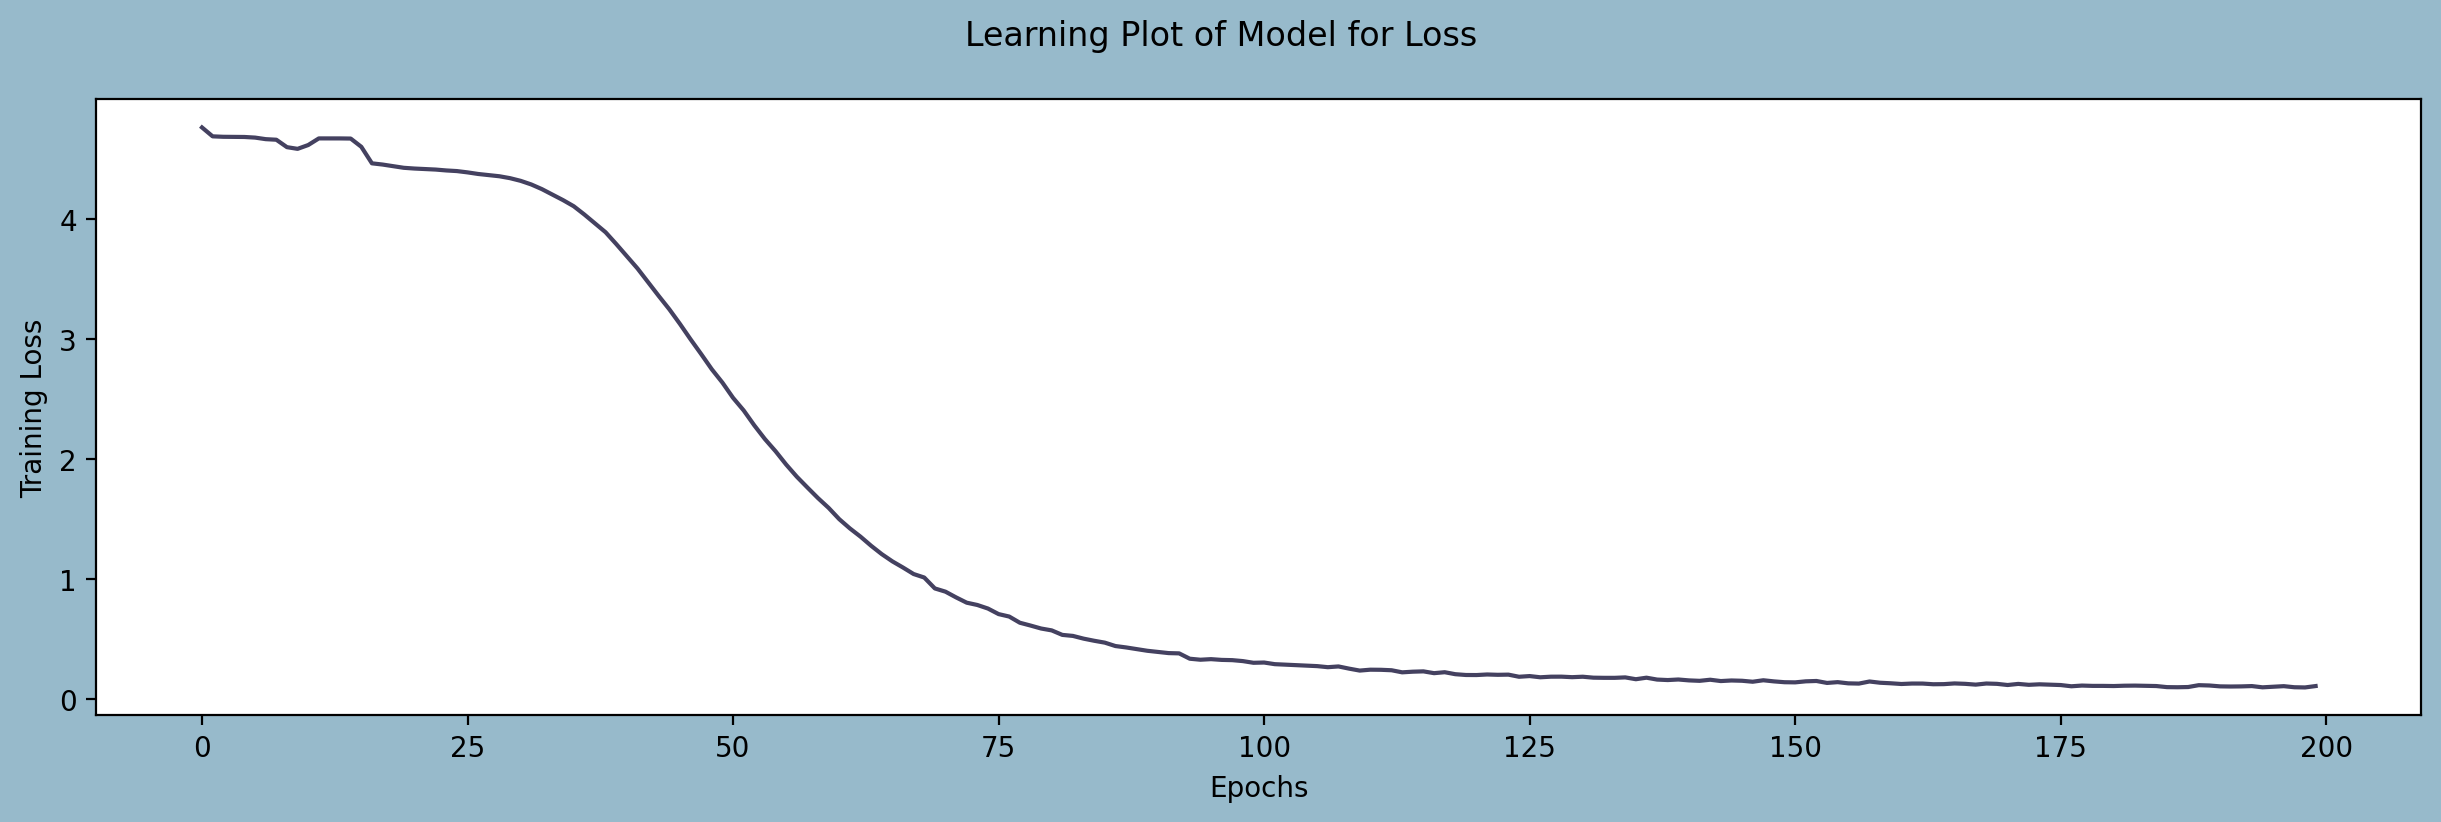

In [46]:
history_df = pd.DataFrame(history.history)
fig = plt.figure(figsize=(15,4), facecolor="#97BACB")
fig.suptitle("Learning Plot of Model for Loss")
pl=sns.lineplot(data=history_df["loss"],color="#444160")
pl.set(ylabel ="Training Loss")
pl.set(xlabel ="Epochs")

In [71]:
model.save('generator.keras')

In [51]:
def show(music):
    display(Image(str(music.write("paper.jpeg"))))
    
def chords_n_notes(Snippet):
    Melody = []
    offset = 0 #Incremental
    for i in Snippet:
        #If it is chord
        if ("." in i or i.isdigit()):
            chord_notes = i.split(".") #Seperating the notes in chord
            notes = [] 
            for j in chord_notes:
                inst_note=int(j)
                note_snip = note.Note(inst_note)            
                notes.append(note_snip)
                chord_snip = chord.Chord(notes)
                chord_snip.offset = offset
                Melody.append(chord_snip)
        # pattern is a note
        else: 
            note_snip = note.Note(i)
            note_snip.offset = offset
            Melody.append(note_snip)
        # increase offset each iteration so that notes do not stack
        offset += 1
    Melody_midi = stream.Stream(Melody)   
    return Melody_midi

# Melody_Snippet = chords_n_notes(Corpus[:100])
# show(Melody_Snippet)

In [54]:
def Malody_Generator(Note_Count):
    seed = X_seed[np.random.randint(0,len(X_seed)-1)]
    Music = ""
    Notes_Generated=[]
    for i in range(Note_Count):
        seed = seed.reshape(1,length,1)
        prediction = model.predict(seed, verbose=0)[0]
        prediction = np.log(prediction) / 1.0 #diversity
        exp_preds = np.exp(prediction)
        prediction = exp_preds / np.sum(exp_preds)
        index = np.argmax(prediction)
        index_N = index/ float(L_symb)   
        Notes_Generated.append(index)
        Music = [reverse_mapping[char] for char in Notes_Generated]
        seed = np.insert(seed[0],len(seed[0]),index_N)
        seed = seed[1:]
    #Now, we have music in form or a list of chords and notes and we want to be a midi file.
    Melody = chords_n_notes(Music)
    Melody_midi = stream.Stream(Melody)   
    return Music,Melody_midi


#getting the Notes and Melody created by the model
Music_notes, Melody = Malody_Generator(100)
# show(Melody)

In [57]:
#To save the generated melody
Melody.write('midi','Melody_Generated.mid')

'Melody_Generated.mid'